In [59]:
# Essential Libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import pandas_profiling as ppf
import calendar


In [60]:
# Modelling libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Data Preparation

In [61]:
customer_data = pd.read_excel("Data/CustomersData.xlsx")
online_sales = pd.read_csv("Data/Online_Sales.csv")
marketing_spend = pd.read_csv("Data/Marketing_Spend.csv")
disc_coupon = pd.read_csv("Data/Discount_Coupon.csv")
tax_amount = pd.read_excel("Data/Tax_amount.xlsx")

### Lets see the data

In [62]:
customer_data.head()

,CustomerID,Gender,Location,Tenure_Months
0,17850,M,Chicago,12
1,13047,M,California,43
2,12583,M,Chicago,33
3,13748,F,California,30
4,15100,M,California,49


In [63]:
online_sales.head()

,CustomerID,Transaction_ID,Transaction_Date,Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status
0,17850,16679,20190101,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used
1,17850,16680,20190101,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used
2,17850,16681,20190101,1/1/2019,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used
3,17850,16682,20190101,1/1/2019,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.5,Not Used
4,17850,16682,20190101,1/1/2019,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used


In [64]:
online_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52924 entries, 0 to 52923
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           52924 non-null  int64  
 1   Transaction_ID       52924 non-null  int64  
 2   Transaction_Date     52924 non-null  int64  
 3   Date                 52924 non-null  object 
 4   Product_SKU          52924 non-null  object 
 5   Product_Description  52924 non-null  object 
 6   Product_Category     52924 non-null  object 
 7   Quantity             52924 non-null  int64  
 8   Avg_Price            52924 non-null  float64
 9   Delivery_Charges     52924 non-null  float64
 10  Coupon_Status        52924 non-null  object 
dtypes: float64(2), int64(4), object(5)
memory usage: 4.4+ MB


In [65]:
## Changing the dtype of the date column
online_sales["Date"] = pd.to_datetime(online_sales["Date"])

In [66]:
marketing_spend.head()

,Date,Offline_Spend,Online_Spend
0,1/1/2019,4500,2424.50
1,1/2/2019,4500,3480.36
2,1/3/2019,4500,1576.38
3,1/4/2019,4500,2928.55
4,1/5/2019,4500,4055.30


In [67]:
marketing_spend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           365 non-null    object 
 1   Offline_Spend  365 non-null    int64  
 2   Online_Spend   365 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 8.7+ KB


In [68]:
# Lets make Some new variables
marketing_spend["Date"] = pd.to_datetime(marketing_spend["Date"])
marketing_spend["Month"] = marketing_spend["Date"].dt.month.apply(lambda x:calendar.month_abbr[x])
marketing_spend["Total_Spend"] = marketing_spend.Offline_Spend+ marketing_spend.Online_Spend

In [69]:

disc_coupon.head()

,Month,Product_Category,Coupon_Code,Discount_pct
0,Jan,Apparel,SALE10,10
1,Feb,Apparel,SALE20,20
2,Mar,Apparel,SALE30,30
3,Jan,Nest-USA,ELEC10,10
4,Feb,Nest-USA,ELEC20,20


In [70]:
tax_amount.head()

,Product_Category,GST
0,Nest-USA,0.10
1,Office,0.10
2,Apparel,0.18
3,Bags,0.18
4,Drinkware,0.18


In [71]:
# Lets make dates a datetime variable
marketing_spend["Date"] = pd.to_datetime(marketing_spend["Date"])
marketing_spend["Month"] = marketing_spend["Date"].dt.month.apply(lambda x:calendar.month_abbr[x])
marketing_spend["Total_Spend"] = marketing_spend.Offline_Spend+ marketing_spend.Online_Spend

# Data Preparation

In [72]:
# Joining the online_sales and customer_data
sales_customer = pd.merge(online_sales,customer_data,on="CustomerID",how="inner").sort_values(by=["CustomerID","Date"])

In [73]:

sales_customer = sales_customer[['CustomerID','Gender', 'Location',
       'Tenure_Months', 'Transaction_ID', 'Transaction_Date',"Date",
       'Product_SKU', 'Product_Description', 'Product_Category', 'Quantity',
       'Avg_Price', 'Delivery_Charges', 'Coupon_Status']]

In [74]:
sales_customer = sales_customer.drop("Transaction_Date",axis=1)

In [75]:
import calendar
sales_customer["Month"]=sales_customer.Date.dt.month.apply(lambda x:calendar.month_abbr[x])

In [76]:
# There is a space Product_Category column name
disc_coupon.columns = ['Month', 'Product_Category', 'Coupon_Code', 'Discount_pct']

In [77]:
## Adding cupon information in that particular month
sales_customer = pd.merge(sales_customer,disc_coupon,on=["Month","Product_Category"],how="left")

In [78]:
## Adding tax information
sales_customer = pd.merge(sales_customer,tax_amount,on="Product_Category",how="left")

In [79]:
sales_customer.Discount_pct = sales_customer.Discount_pct/100

In [81]:
sales_customer.isna().sum()

CustomerID               0
Gender                   0
Location                 0
Tenure_Months            0
Transaction_ID           0
Date                     0
Product_SKU              0
Product_Description      0
Product_Category         0
Quantity                 0
Avg_Price                0
Delivery_Charges         0
Coupon_Status            0
Month                    0
Coupon_Code            400
Discount_pct           400
GST                      0
dtype: int64

In [83]:
# First lets fill nan with 0 to make calculations possible
# Where there is no discount is given 
sales_customer.fillna(0,inplace=True)

In [88]:
# We can encode coupon status to be 0 for not used and clicked and 1 for used 
# It will also make calculations easy 
# just multiply with the coupon status encoded column to add or not add the discount percentage

In [89]:

sales_customer["Invoice_Value"] = (sales_customer.Quantity*sales_customer.Avg_Price)*(1-sales_customer.Discount_pct*sales_customer.Coupon_Status.replace(['Used', 'Clicked','Not Used'],[1,0,0]))*(1+sales_customer.GST)+sales_customer.Delivery_Charges

In [92]:
sales_customer.to_csv("Summaries/Final_DF.csv")

# EDA

In [95]:
df_eda = sales_customer.copy()

## Understanding how many customers acquired every month

In [99]:
cust_each_month = df_eda[~df_eda.CustomerID.duplicated()].groupby("Month")["CustomerID"].count().reindex(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]).reset_index()

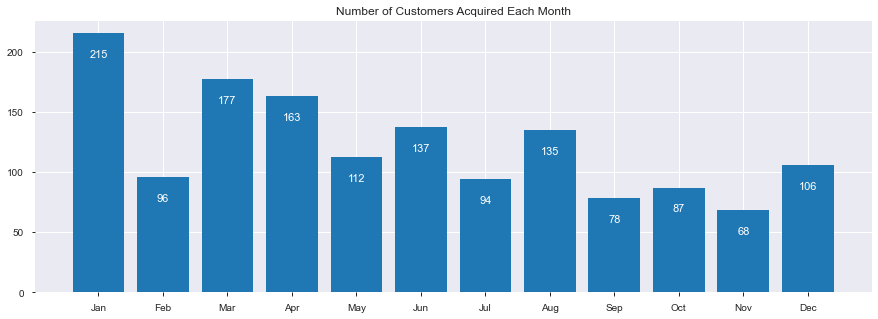

In [100]:
cust_each_month.columns = ["Month","Customers_Acquired"]
plt.figure(figsize = (15,5))
bars = plt.bar(cust_each_month.Month,cust_each_month.Customers_Acquired)
plt.title("Number of Customers Acquired Each Month")
for bar in bars:
    plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height() - 20, str(int(bar.get_height())), 
                 ha='center', color='w', fontsize=11)


## Understanding the retention of customers on month on month basis

In [102]:
# Total customers in each month 
cust_each_month["At_end"] = df_eda.groupby("Month")["CustomerID"].nunique().reindex(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]).values
cust_each_month["In_Beginning"] = cust_each_month.At_end.shift(1).fillna(0)
cust_each_month["Retention"] = ((cust_each_month.At_end - cust_each_month.Customers_Acquired)/cust_each_month.In_Beginning)*100
cust_each_month = cust_each_month.fillna(0)

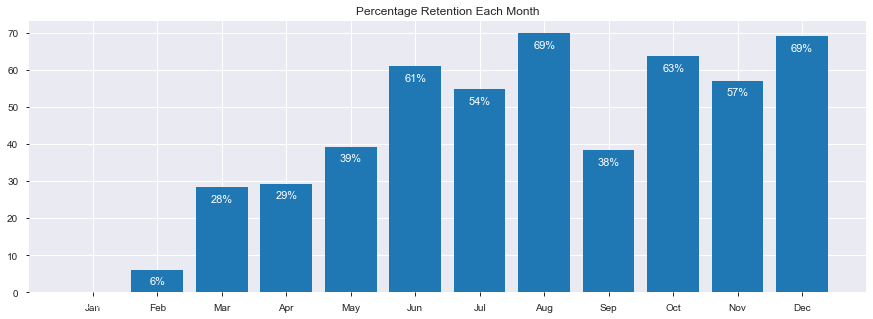

In [103]:
plt.figure(figsize = (15,5))
bars = plt.bar(cust_each_month.Month,cust_each_month.Retention)
plt.title("Percentage Retention Each Month")
for bar in bars:
    plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height() - 4, str(int(bar.get_height()))+"%", 
                 ha='center', color='w', fontsize=11)


## How the revenues from existing/new customers on month on month basis

In [106]:
# ALL THE CUSTOMERS THAT ARE NEW IN ANY MONTH
df_new = df_eda[~df_eda.CustomerID.duplicated()].groupby("Month")[["CustomerID","Invoice_Value"]].agg({"CustomerID":"count","Invoice_Value":sum}).reindex(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]).reset_index()
# ALL THE CUSTOMERS THAT ARE ALREADY CUSTOMERS
df_existing = df_eda[df_eda.CustomerID.duplicated()].groupby("Month")[["CustomerID","Invoice_Value"]].agg({"CustomerID":"count","Invoice_Value":sum}).reindex(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]).reset_index()

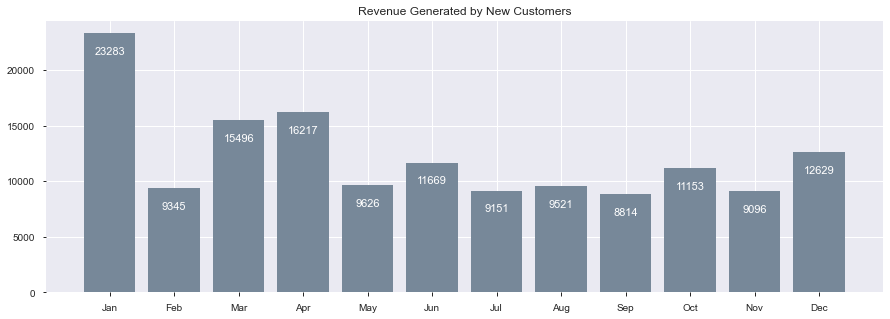

Text(0.5, 1.0, 'Revenue Generated by New Customers')

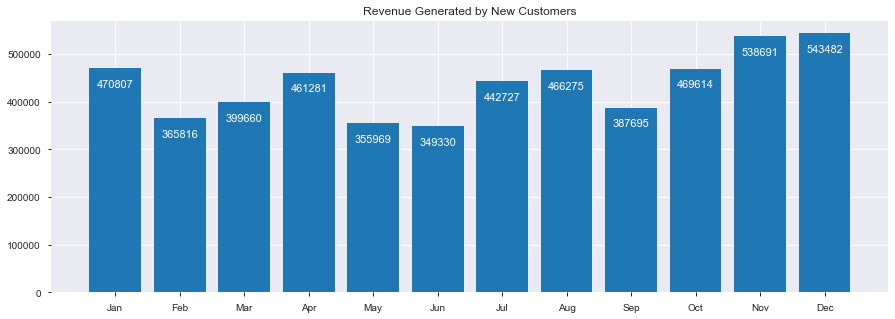

In [107]:
plt.figure(figsize = (15,5))
bars = plt.bar(df_new.Month,df_new.Invoice_Value,color='lightslategrey')
plt.title("Revenue Generated by New Customers")
for bar in bars:
    plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height() - 1900, str(int(bar.get_height())), 
                 ha='center', color='w', fontsize=11)
plt.show()

plt.figure(figsize=(15,5))
bars = plt.bar(df_new.Month,df_existing.Invoice_Value)
for bar in bars:
    plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height() - 40000, str(int(bar.get_height())), 
                 ha='center', color='w', fontsize=11)
plt.title("Revenue Generated by New Customers")

## Analyse KPI’s like Revenue, number of orders, average order value, number of customers (existing/new), quantity, by category, by month, by week, by day etc…

### By Category

In [110]:
# By product Category
df_category = df_eda.groupby("Product_Category").agg({"Invoice_Value":"sum","Transaction_ID":"count"}).round().reset_index()
df_category["Average Order Value"] = df_category.Invoice_Value/df_category.Transaction_ID
df_category.columns = ['Product_Category', 'Invoice_Value', 'Transaction_ID(Count)',
       'Average Order Value']

In [111]:
df_category

,Product_Category,Invoice_Value,Transaction_ID(Count),Average Order Value
0,Accessories,10199.0,234,43.585470
1,Android,1116.0,43,25.953488
2,Apparel,827829.0,18126,45.670804
3,Backpacks,10813.0,89,121.494382
4,Bags,193627.0,1882,102.883634
5,Bottles,10172.0,268,37.955224
6,Drinkware,272622.0,3483,78.272179
7,Fun,8995.0,160,56.218750
8,Gift Cards,19447.0,159,122.308176
9,Google,13169.0,105,125.419048


### By Month

In [116]:
df_month = df_eda.groupby("Month").agg({"Invoice_Value":"sum","Transaction_ID":"count"}).round().reindex(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
df_month["Average Order Value"] = df_month.Invoice_Value/df_month.Transaction_ID
df_month.columns = ['Invoice_Value', 'Transaction_ID(Count)',
       'Average Order Value']

df_month.reset_index()

,Month,Invoice_Value,Transaction_ID(Count),Average Order Value
0,Jan,494091.0,4063,121.607433
1,Feb,375162.0,3284,114.239342
2,Mar,415158.0,4346,95.526461
3,Apr,477499.0,4150,115.060000
4,May,365596.0,4572,79.964129
5,Jun,361000.0,4193,86.095874
6,Jul,451878.0,5251,86.055608
7,Aug,475797.0,6150,77.365366
8,Sep,396510.0,4288,92.469683
9,Oct,480767.0,4164,115.457973


### By Week

In [120]:
sales_customer["Date"] = pd.to_datetime(sales_customer["Date"])
sales_customer["Week"] = sales_customer.Date.dt.isocalendar().week
df_week = sales_customer.groupby("Week").agg({"Invoice_Value":"sum","Transaction_ID":"count"})
df_week["Average Order Value"] = df_week.Invoice_Value/df_week.Transaction_ID
df_week.columns = ['Invoice_Value', 'Transaction_ID(Count)',
       'Average Order Value']
df_week.reset_index()

,Week,Invoice_Value,Transaction_ID(Count),Average Order Value
0,1,131077.87837,1056,124.126779
1,2,104569.21104,829,126.138976
2,3,106868.31322,842,126.921987
3,4,109560.62304,943,116.183057
4,5,105695.03401,926,114.141505
5,6,89697.85810,749,119.756820
6,7,101107.17060,881,114.764098
7,8,98127.24106,876,112.017398
8,9,83657.95910,810,103.281431
9,10,92773.01870,1012,91.672943


## Understand the trends/seasonality of sales by category, location, month etc…

Text(0.5, 1.0, 'Sales for different locations')

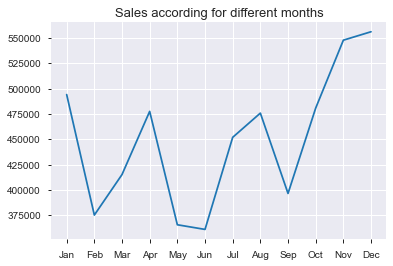

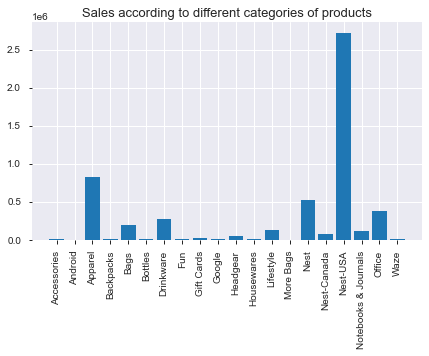

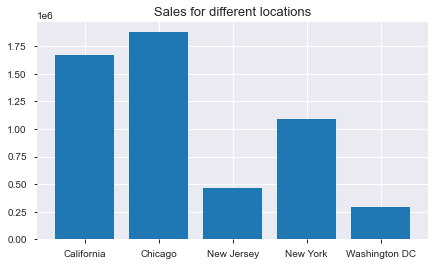

In [122]:
month = df_eda.groupby("Month")["Invoice_Value"].sum().reindex(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]).reset_index()
category = df_eda.groupby("Product_Category")["Invoice_Value"].sum().reset_index()
plt.plot(month.Month,month.Invoice_Value)
plt.title("Sales according for different months",size=13)

plt.figure(figsize=(7,4))
plt.bar(category.Product_Category,category.Invoice_Value)
xaxis = plt.gca().xaxis
for item in xaxis.get_ticklabels():
    # we can use artist methods or function on these tick labels
    item.set_rotation(90)
plt.title("Sales according to different categories of products",size=13)    


location = df_eda.groupby("Location")["Invoice_Value"].sum().reset_index()
plt.figure(figsize=(7,4))
plt.bar(location.Location,location.Invoice_Value)
plt.title("Sales for different locations",size=13)

## How number order varies and sales with different days?

Text(0.5, 1.0, 'Number of orders placed on each day')

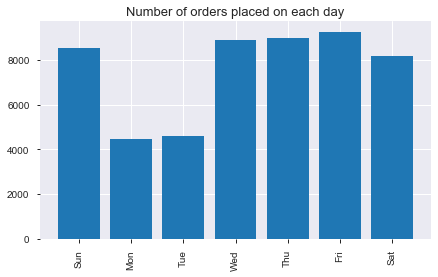

In [124]:
import calendar
df_eda["Day"] = df_eda.Date.dt.weekday.apply(lambda x: calendar.day_abbr[x])

orders = df_eda.groupby("Day")["Transaction_ID"].count().reindex(["Sun","Mon","Tue","Wed","Thu","Fri","Sat"]).reset_index()
plt.figure(figsize=(7,4))
plt.bar(orders.Day,orders.Transaction_ID)
xaxis = plt.gca().xaxis
for item in xaxis.get_ticklabels():
    # we can use artist methods or function on these tick labels
    item.set_rotation(90)
plt.title("Number of orders placed on each day",size=13) 

Text(0.5, 1.0, 'Total Sale on each day')

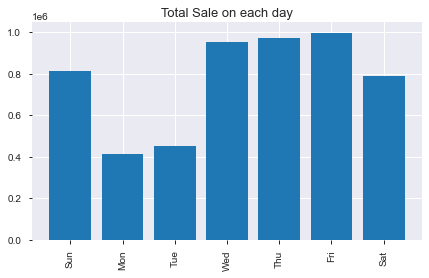

In [125]:
sales = df_eda.groupby("Day")["Invoice_Value"].sum().reindex(["Sun","Mon","Tue","Wed","Thu","Fri","Sat"]).reset_index()
plt.figure(figsize=(7,4))
plt.bar(sales.Day,sales.Invoice_Value)
xaxis = plt.gca().xaxis
for item in xaxis.get_ticklabels():
    # we can use artist methods or function on these tick labels
    item.set_rotation(90)
plt.title("Total Sale on each day",size=13) 

## Calculate the Revenue, Marketing spend, percentage of marketing spend out of revenue, Tax, percentage of delivery charges by month.

#### % of Marketing Spend

In [128]:
marketing_spend = pd.read_csv("Data/Marketing_Spend.csv")

In [129]:
marketing_spend["Date"] = pd.to_datetime(marketing_spend["Date"])
marketing_spend["Month"] = marketing_spend["Date"].dt.month.apply(lambda x:calendar.month_abbr[x])
marketing_spend["Total_Spend"] = marketing_spend.Offline_Spend+ marketing_spend.Online_Spend

In [131]:
Revenue = df_eda.groupby("Month")["Invoice_Value"].sum().reindex(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]).reset_index()
ms = marketing_spend.groupby("Month")["Total_Spend"].sum().reindex(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]).reset_index()

In [133]:
data = pd.merge(Revenue,ms,on="Month",how="outer")
data.columns = ["Month","Revenue","Marketing_Spend"]

data["Pct_Spend"] = (data.Marketing_Spend/data.Revenue)*100

data

,Month,Revenue,Marketing_Spend,Pct_Spend
0,Jan,494090.54875,154928.95,31.356388
1,Feb,375162.04730,137107.92,36.546319
2,Mar,415157.79044,122250.09,29.446657
3,Apr,477498.59102,157026.83,32.885297
4,May,365596.02956,118259.64,32.347080
5,Jun,361000.17429,134318.14,37.207223
6,Jul,451878.40904,120217.85,26.604026
7,Aug,475796.87554,142904.15,30.034697
8,Sep,396510.49254,135514.54,34.176785
9,Oct,480767.36981,151224.65,31.454849


#### % of delivery charges by month

In [135]:
dlvry = df_eda.groupby("Month")[["Delivery_Charges","Invoice_Value"]].sum().reindex(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]).reset_index()
dlvry["Pct_Delivery_Charge"]=dlvry.Delivery_Charges/dlvry.Invoice_Value*100
dlvry

,Month,Delivery_Charges,Invoice_Value,Pct_Delivery_Charge
0,Jan,59242.32,494090.54875,11.990175
1,Feb,49216.60,375162.04730,13.118758
2,Mar,60799.94,415157.79044,14.645020
3,Apr,41481.74,477498.59102,8.687301
4,May,41396.17,365596.02956,11.322927
5,Jun,37513.58,361000.17429,10.391568
6,Jul,48723.93,451878.40904,10.782531
7,Aug,61099.57,475796.87554,12.841524
8,Sep,41005.42,396510.49254,10.341572
9,Oct,45961.88,480767.36981,9.560108


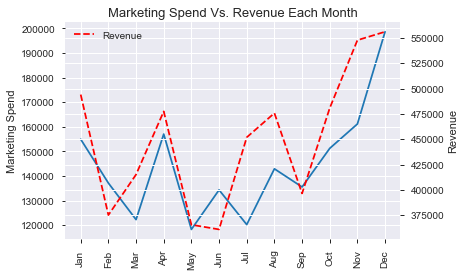

In [136]:
data
fig, ax = plt.subplots()
ax.plot(data.Month,data.Marketing_Spend,label="Marketing Spend")
xaxis = plt.gca().xaxis
for item in xaxis.get_ticklabels():
    # we can use artist methods or function on these tick labels
    item.set_rotation(90)
ax.set_ylabel("Marketing Spend")
    
ax2 = ax.twinx()
ax2.plot(data.Month,data.Revenue,"--r",label="Revenue")
ax2.set_ylabel("Revenue")
# plt.plot(data.Month,data.Revenue)
plt.title("Marketing Spend Vs. Revenue Each Month",size=13) 
plt.legend()

### Which product was appeared in the transactions

In [139]:
df_eda.groupby("Product_Description")["Transaction_ID"].count().idxmax()

'Nest Learning Thermostat 3rd Gen-USA - Stainless Steel'

###  Which product was purchased mostly based on the quantity?

In [142]:
df_eda.groupby("Product_Description")["Quantity"].sum().idxmax()

'Maze Pen'